In [764]:
#!pip install transformers
#Legacy transformers is giving a type error, so used transformers 3
!pip install transformers==3

python(67566) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


DEPRECATION: Loading egg at /Users/iresh/anaconda3/lib/python3.11/site-packages/fasttext-0.9.2-py3.11-macosx-11.1-arm64.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..
  Using cached transformers-3.0.0-py3-none-any.whl (754 kB)
  Using cached tokenizers-0.8.0rc4.tar.gz (96 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached sentencepiece-0.1.99-cp311-cp311-macosx_11_0_arm64.whl (1.2 MB)
  Using cached sacremoses-0.0.53-py3-none-any.whl
  error: subprocess-exited-with-error
  
  × Building wheel for tokenizers (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [48 lines of output]
      /private/var/folders/sb/fkjtwlsd2rn4zxgn65djngl80000gn/T/pip-build-env-q6hsvlma/overlay/lib/python3.11/site-packages/setuptools/dist.py:314: InformationOnly: Normalizing '0.8.0.rc4' to '0.8.0rc4'
        self.m

In [765]:
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

# Torch ml libs
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

# misc.
import warnings
warnings.filterwarnings('ignore')

In [766]:
# Set intial variables and constants
%config InlineBackend.figure_format='retina'

# for some graphs
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

# to reproduce the results
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Set GPU/ mine does not have CUDA, so CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [767]:
#Data file with multiple added colums from previous task analysis
df = pd.read_csv('/path/to/cleanedWithAll.csv')
df.shape

(9954, 10)

In [768]:
df.head()

,Review,Rating,sentiStrength,sentiStrengthNormalized,vaderValue,textBlobValues,StandardRating,StandardVaderRatings,StandardTBRatings,new_reviews
0,"The ambience was good, food was quite good . h...",5,3,1,0.9664,0.660000,1,1,1,ambience good food quite good saturday lunch c...
1,Ambience is too good for a pleasant evening. S...,5,2,1,0.9360,0.606667,1,1,1,ambience good pleasant evening service prompt ...
2,A must try.. great food great ambience. Thnx f...,5,2,1,0.9186,0.540000,1,1,1,must try great food great ambience thnx servic...
3,Soumen das and Arun was a great guy. Only beca...,5,2,1,0.8591,0.500000,1,1,1,soumen das arun great guy behavior sincerety g...
4,Food is good.we ordered Kodi drumsticks and ba...,5,2,1,0.9201,0.577500,1,1,1,food goodwe ordered kodi drumsticks basket mut...


In [769]:
#to view the nulls
# 17 nulls in the new_review becasue of imoji removal
#self note: add huggingface to consider emojis
df.isnull().sum()

Review                      0
Rating                      0
sentiStrength               0
sentiStrengthNormalized     0
vaderValue                  0
textBlobValues              0
StandardRating              0
StandardVaderRatings        0
StandardTBRatings           0
new_reviews                17
dtype: int64

Text(0.5, 0, 'review score')

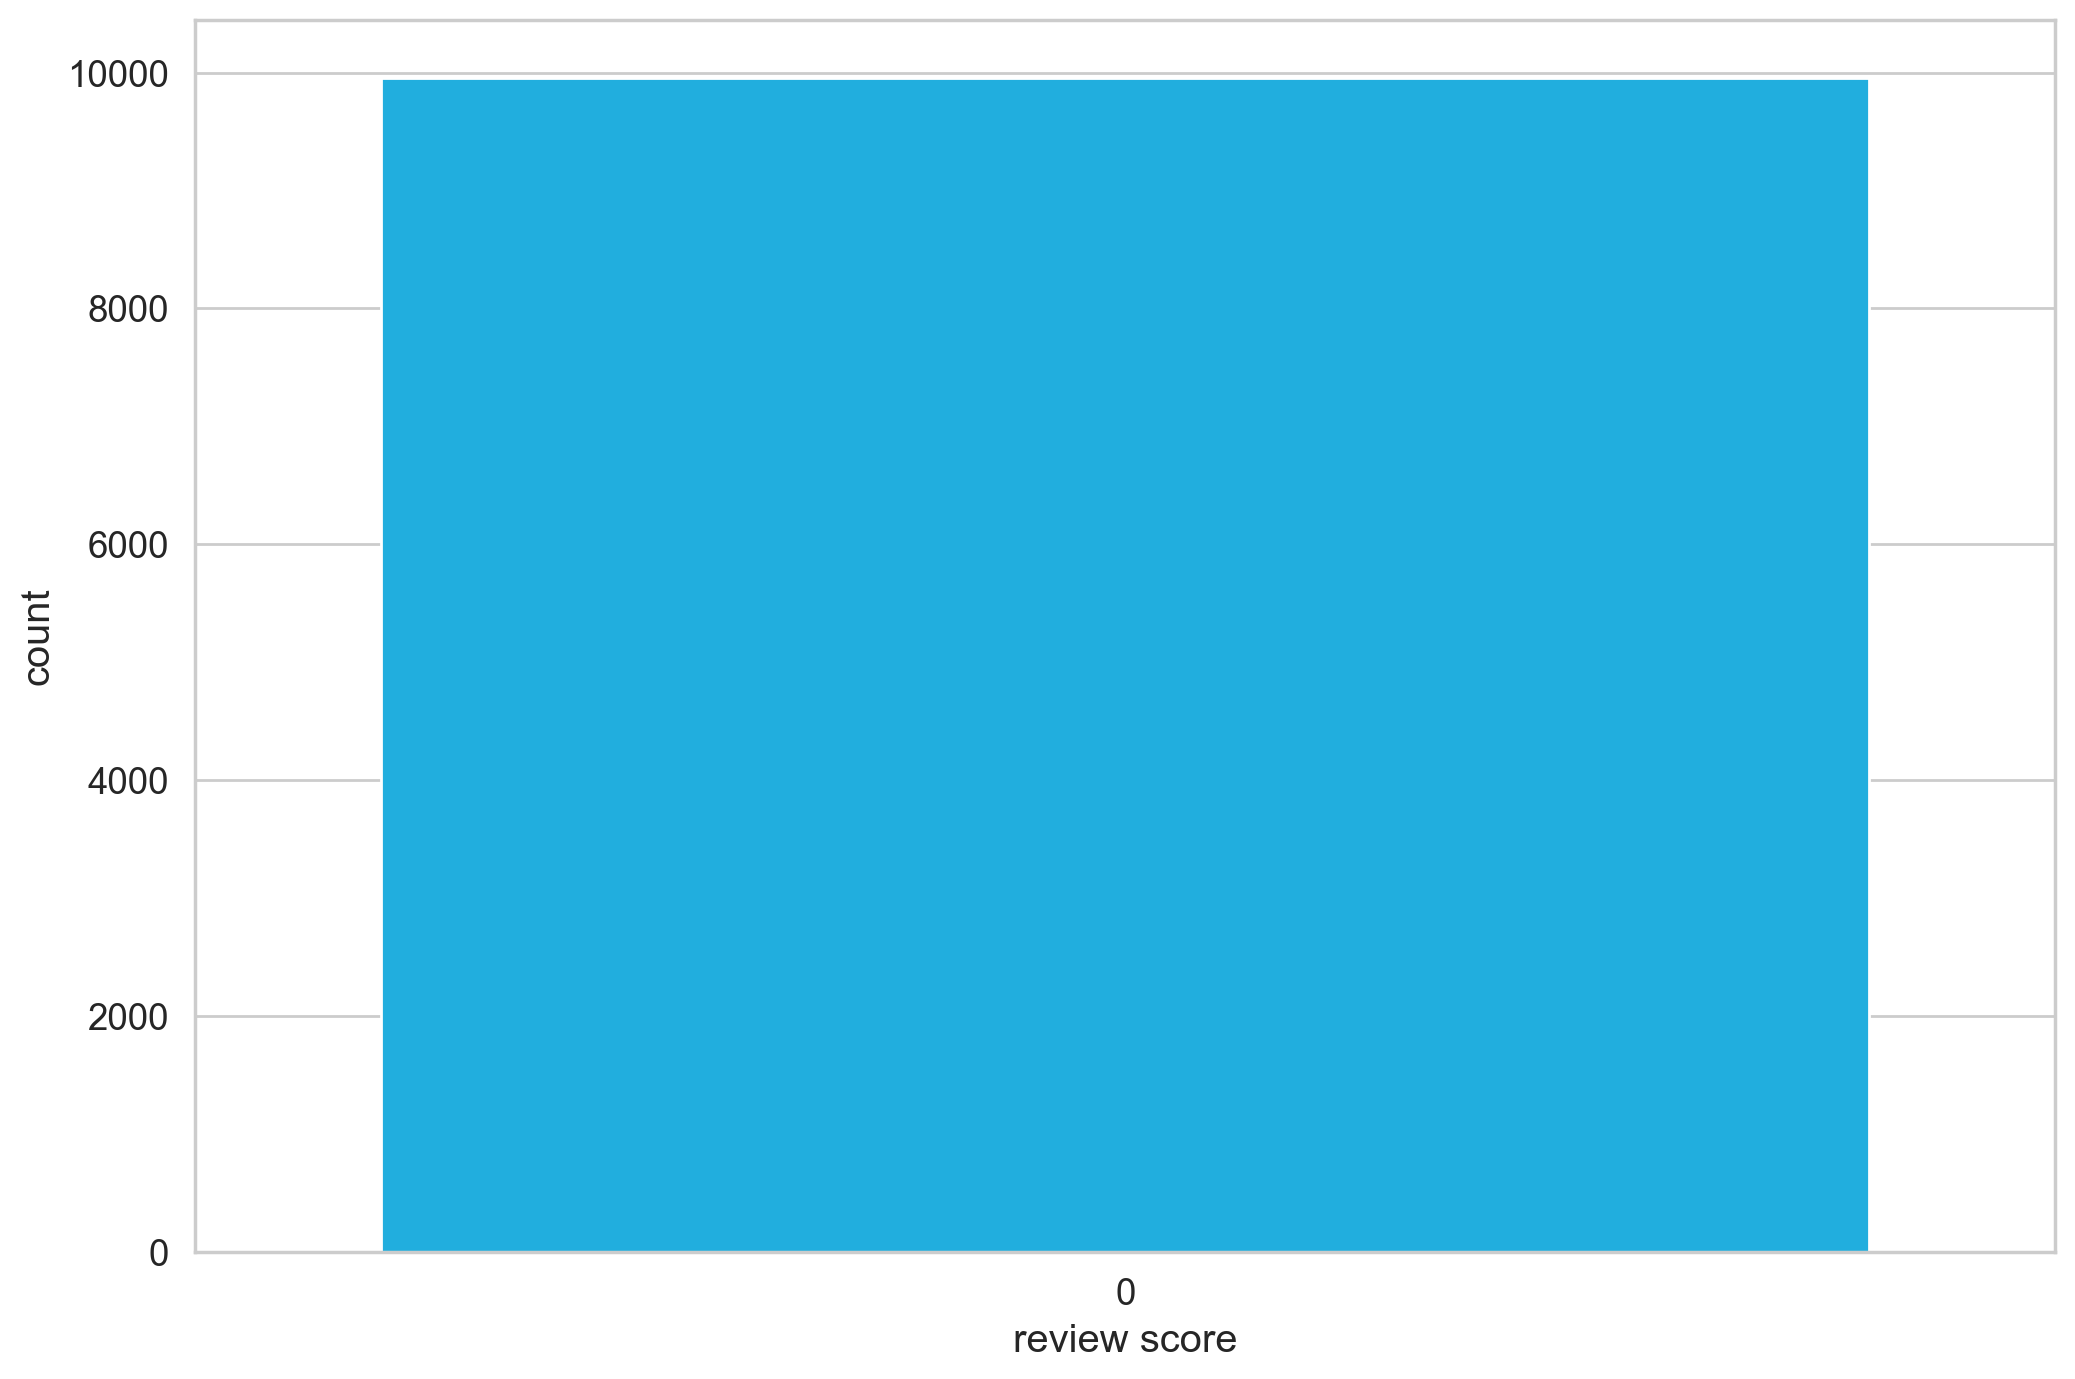

In [770]:
sns.countplot(df.StandardRating)
plt.xlabel('review score')

In [771]:
# coveting rating (1-5) to class
def to_sentiment(rating):
    
    rating = int(rating)
    
    # Convert to class
    if rating <= 2:
        return 0
    elif rating == 3:
        return 1
    else:
        return 2

# Apply to the dataset to the col sentiment
df['sentiment'] = df.Rating.apply(to_sentiment)

In [772]:
#capped to 5000 due to long traning times
 

In [773]:
# Plot the distribution
class_names = ['negative', 'neutral', 'positive']
#ax = sns.countplot(df.sentiment)
#plt.xlabel('review sentiment')
#ax.set_xticklabels(class_names)

In [774]:
# bert-base-cased model used for general use, can use other models here. self note to test with other models
MODEL_NAME = 'bert-base-cased'

# Build a bert based tokenizer
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)


In [775]:
print(tokenizer.sep_token, tokenizer.sep_token_id) # marker for ending of a sentence
print(tokenizer.cls_token, tokenizer.cls_token_id) # start of each sentence, so BERT knows we’re doing classification
print(tokenizer.pad_token, tokenizer.pad_token_id) # special token for padding
print(tokenizer.unk_token, tokenizer.unk_token_id) # tokens not found in training set 


[SEP] 102
[CLS] 101
[PAD] 0
[UNK] 100


In [776]:
# Store length of each review 
token_lens = []

# Iterate through the reviews
for txt in df.Review:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Text(0.5, 0, 'Token count')

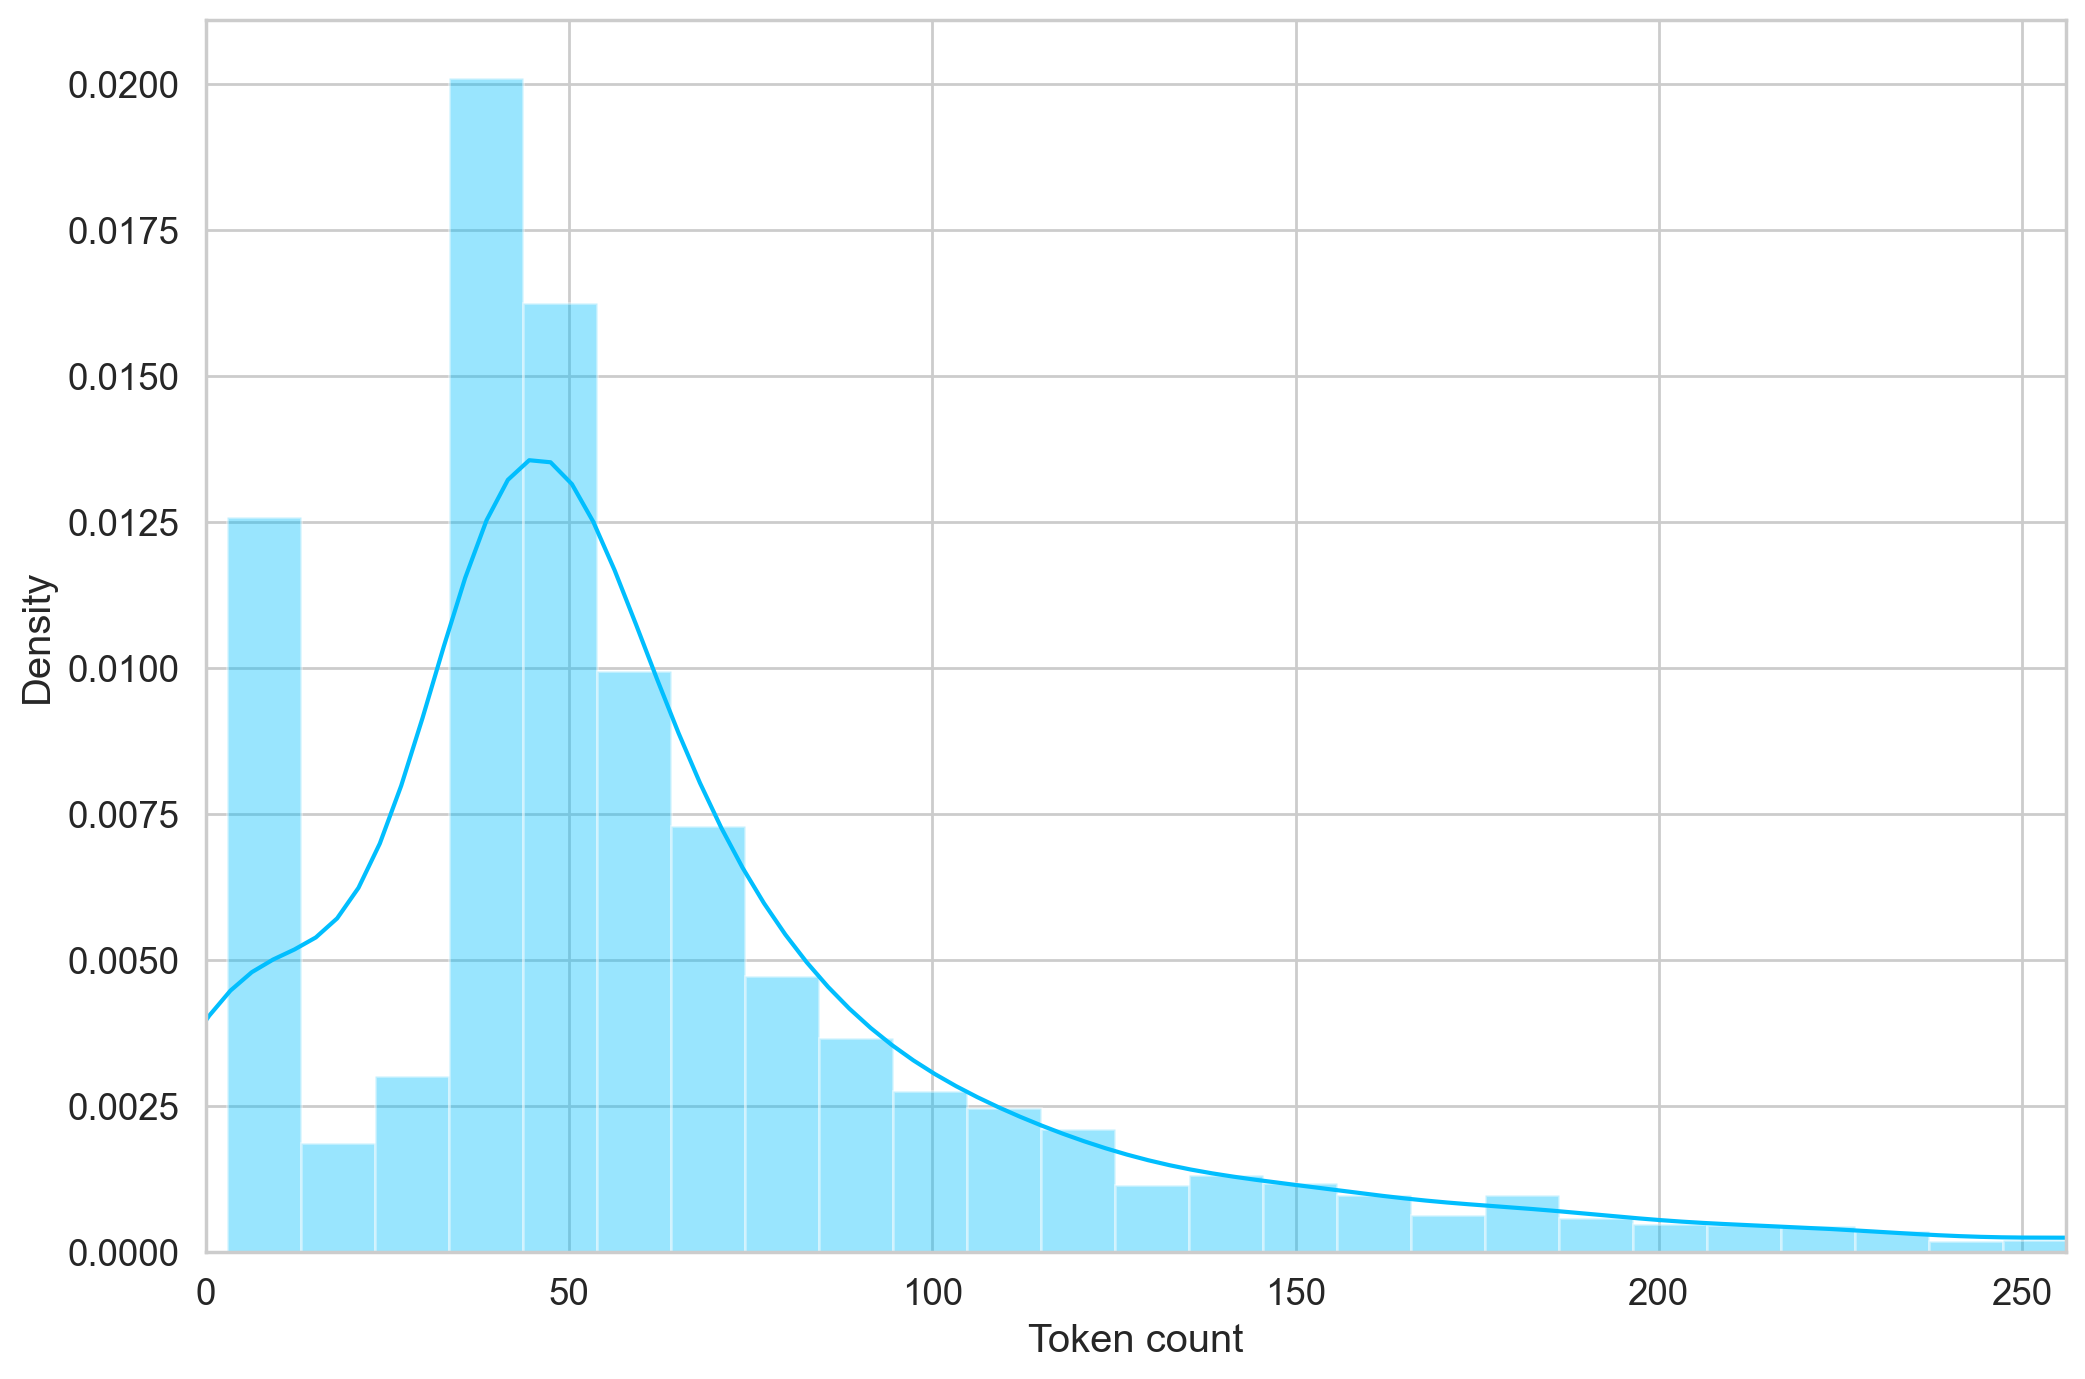

In [777]:
#to view token density
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count')

In [778]:
#capped at 512 to reduce the tranning time. max 3500 needed
MAX_LEN = 512

In [779]:
#data generator class.
class GPReviewDataset(Dataset):
    # Constructor
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    # Length init method
    def __len__(self):
        return len(self.reviews)
    
    # get item init method
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        
        # return Encoded format
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        # returning review test as well, for prediction validation
        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

In [780]:
#Create a 0.8 train data and 0.1 test and 0.1 validation data

df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)
print(df_train.shape, df_val.shape, df_test.shape)

(4000, 11) (500, 11) (500, 11)


In [781]:
#Cdataloader to return data in batches.
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df.Review.to_numpy(),
        targets=df.sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
    )

In [782]:
# create  data loaders for train, test and val
BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [783]:
#just an example

data = next(iter(train_data_loader))
print(data.keys())

print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])
torch.Size([16, 60])
torch.Size([16, 60])
torch.Size([16])


In [784]:
# Loading the basic bert model 
bert_model = BertModel.from_pretrained(MODEL_NAME,return_dict=False)

In [785]:
# Build the Sentiment Classifier class 
# dropout layer to have a full layer for the output. 
# returning the raw output of the last layer 
# coz its needed for the loss function in PyTorch to work. 
# with an instance this can be moved it to the GPU, dont do it colab!!!
class SentimentClassifier(nn.Module):
    
    # Constructor class 
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    
    # Forward propagaion class
    def forward(self, input_ids, attention_mask):
        bert_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        pooled_output = bert_output.pooler_output # Accessing the pooled output
        #  Add a dropout layer
        output = self.drop(pooled_output)
        return self.out(output)
    
    


In [786]:
# init the model and move to classifier
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [787]:
# Number of hidden units
print(bert_model.config.hidden_size)

768


In [788]:
# Number of iterations 
EPOCHS = 10

# Optimizer Adam 
# AdamW optimizer provided by Hugging Face, AdamW corrects weight decay
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Set the loss function 
loss_fn = nn.CrossEntropyLoss().to(device)

In [789]:
#for a single training iteration
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        
        # Backward prop
        loss.backward()
        
        # Gradient Descent
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    
    return correct_predictions.double() / n_examples, np.mean(losses)

In [790]:
#Whis function is to evaluate model performance
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            print(type(input_ids))
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            # Get model ouptuts
            outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
            
            _, preds = torch.max(outputs, dim=1)#gives two vales
            loss = loss_fn(outputs, targets)
            
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
            
    return correct_predictions.double() / n_examples, np.mean(losses)

In [791]:
#training Loop and store the best training state. remove to save time
%%time 

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    
    # Show details 
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)
    
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )
    
    print(f"Train loss {train_loss} accuracy {train_acc}")
    
    # Get model performance (accuracy and loss)
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )
    
    print(f"Val   loss {val_loss} accuracy {val_acc}")
    print()
    
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    # If we beat prev performance
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.5452548117041588 accuracy 0.79625
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Val   loss 0.418383238138631 accuracy 0.838

Epoch 2/10
----------
Train loss 0.3377212577909231 accuracy 0.88075
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torc

#model evaluation

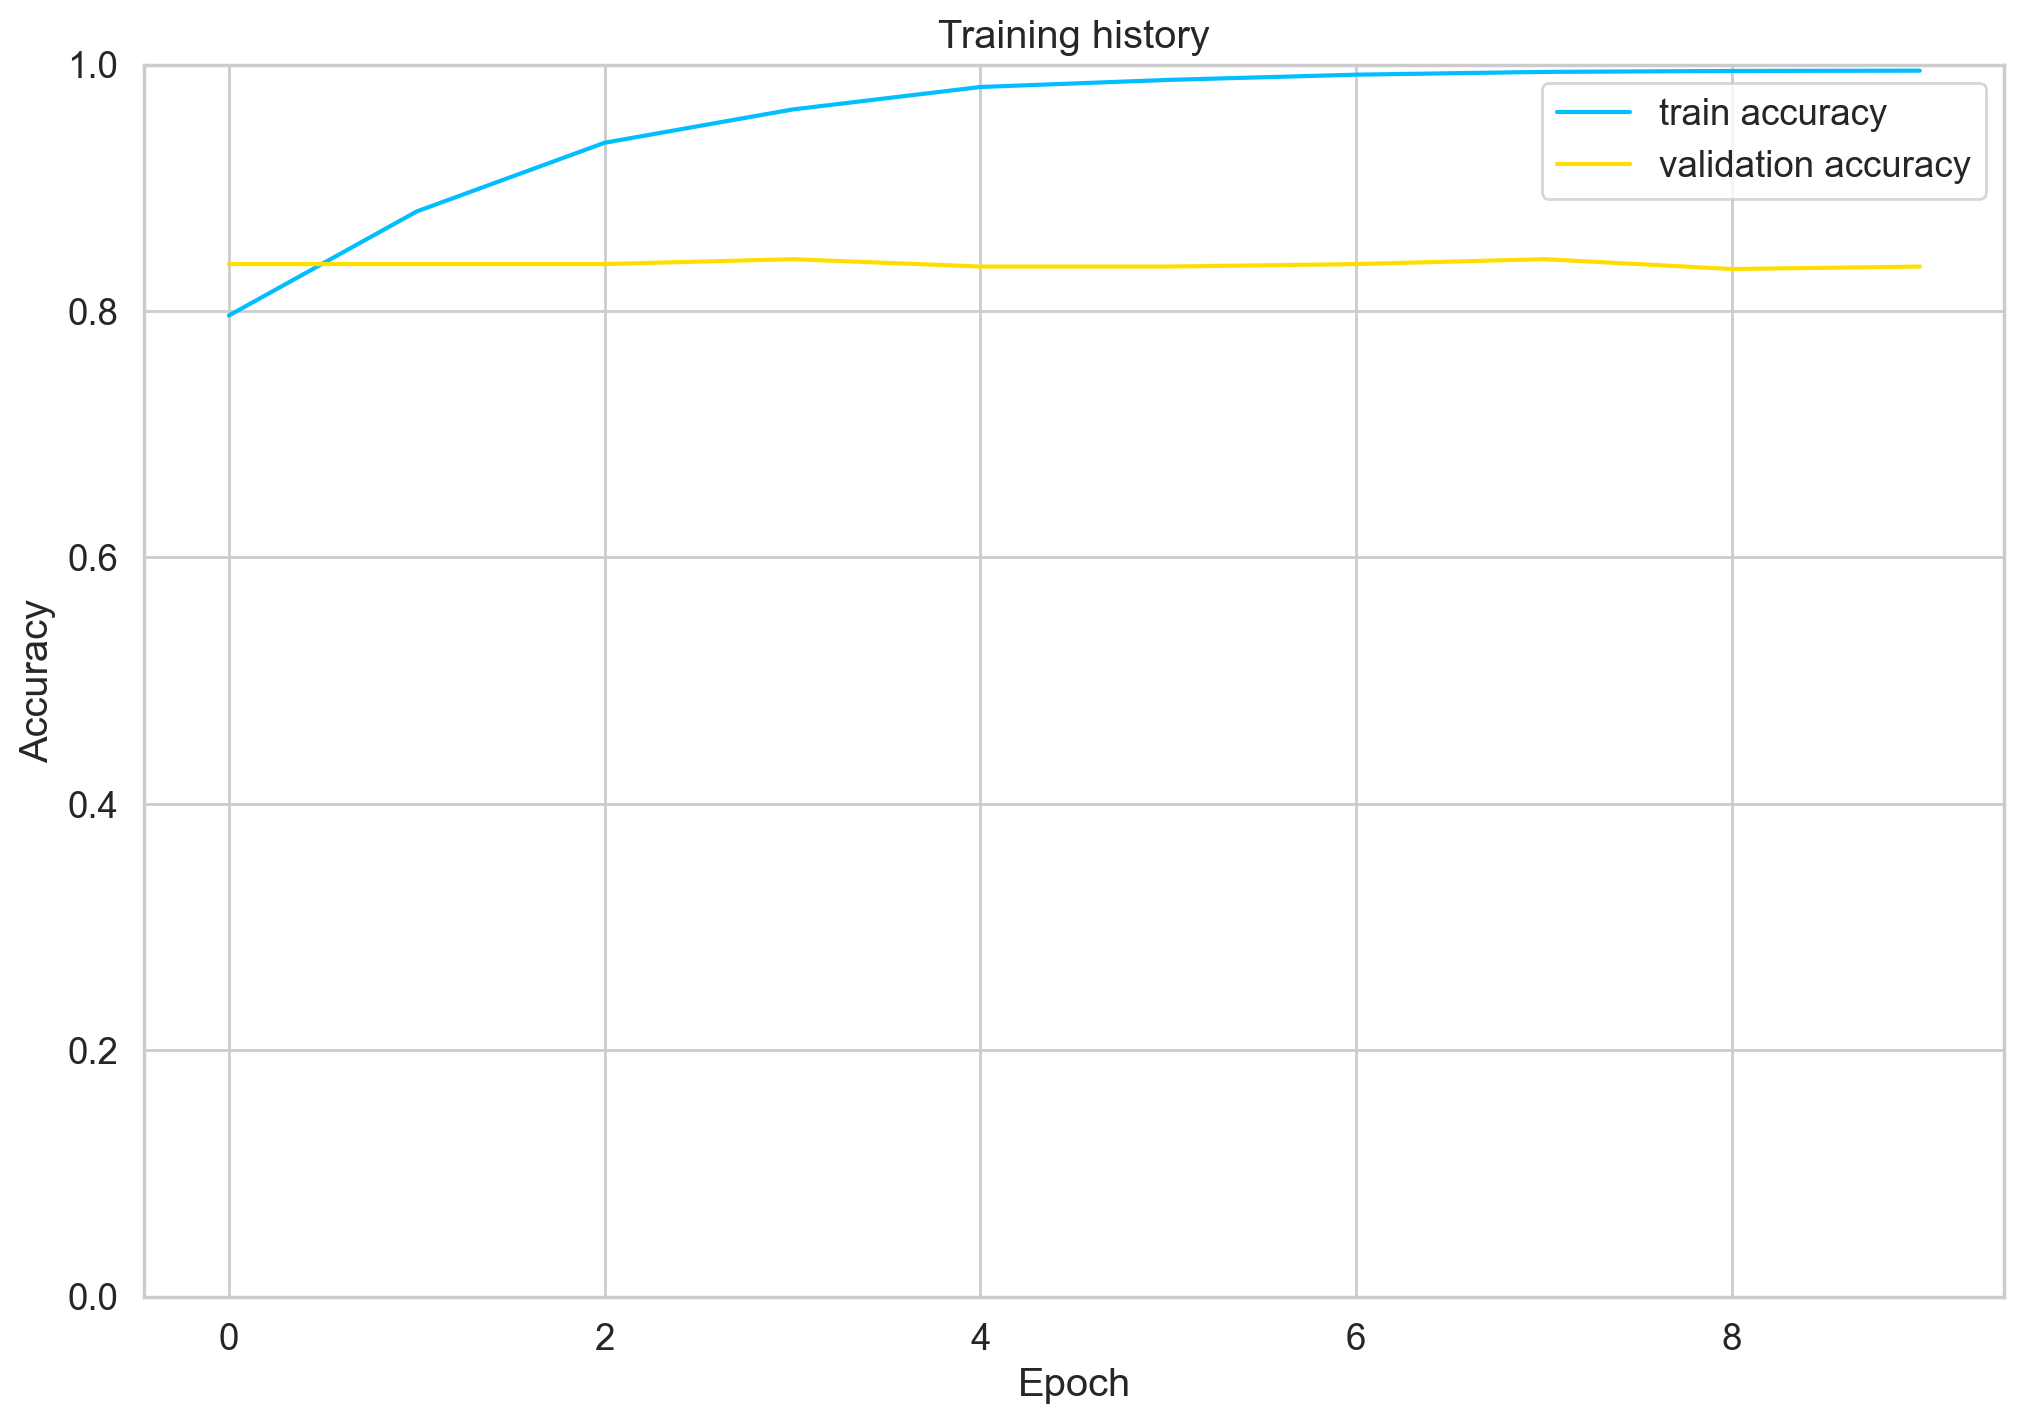

In [792]:
#to plot the training and validation accuracy.
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

# Graph chars
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [793]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


0.83

In [794]:
# Define a helper function to get predictions from our models. 
# self note : modify to a evaluation function later, 
# to store the text of the reviews and the predicted probabilities

def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            # Get outouts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()

    return review_texts, predictions, prediction_probs, real_values


In [795]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    test_data_loader
)

In [796]:
print(classification_report(y_test, y_pred, target_names=class_names))


              precision    recall  f1-score   support

    negative       0.83      0.81      0.82       118
     neutral       0.42      0.39      0.40        62
    positive       0.90      0.92      0.91       320

    accuracy                           0.83       500
   macro avg       0.72      0.71      0.71       500
weighted avg       0.82      0.83      0.83       500



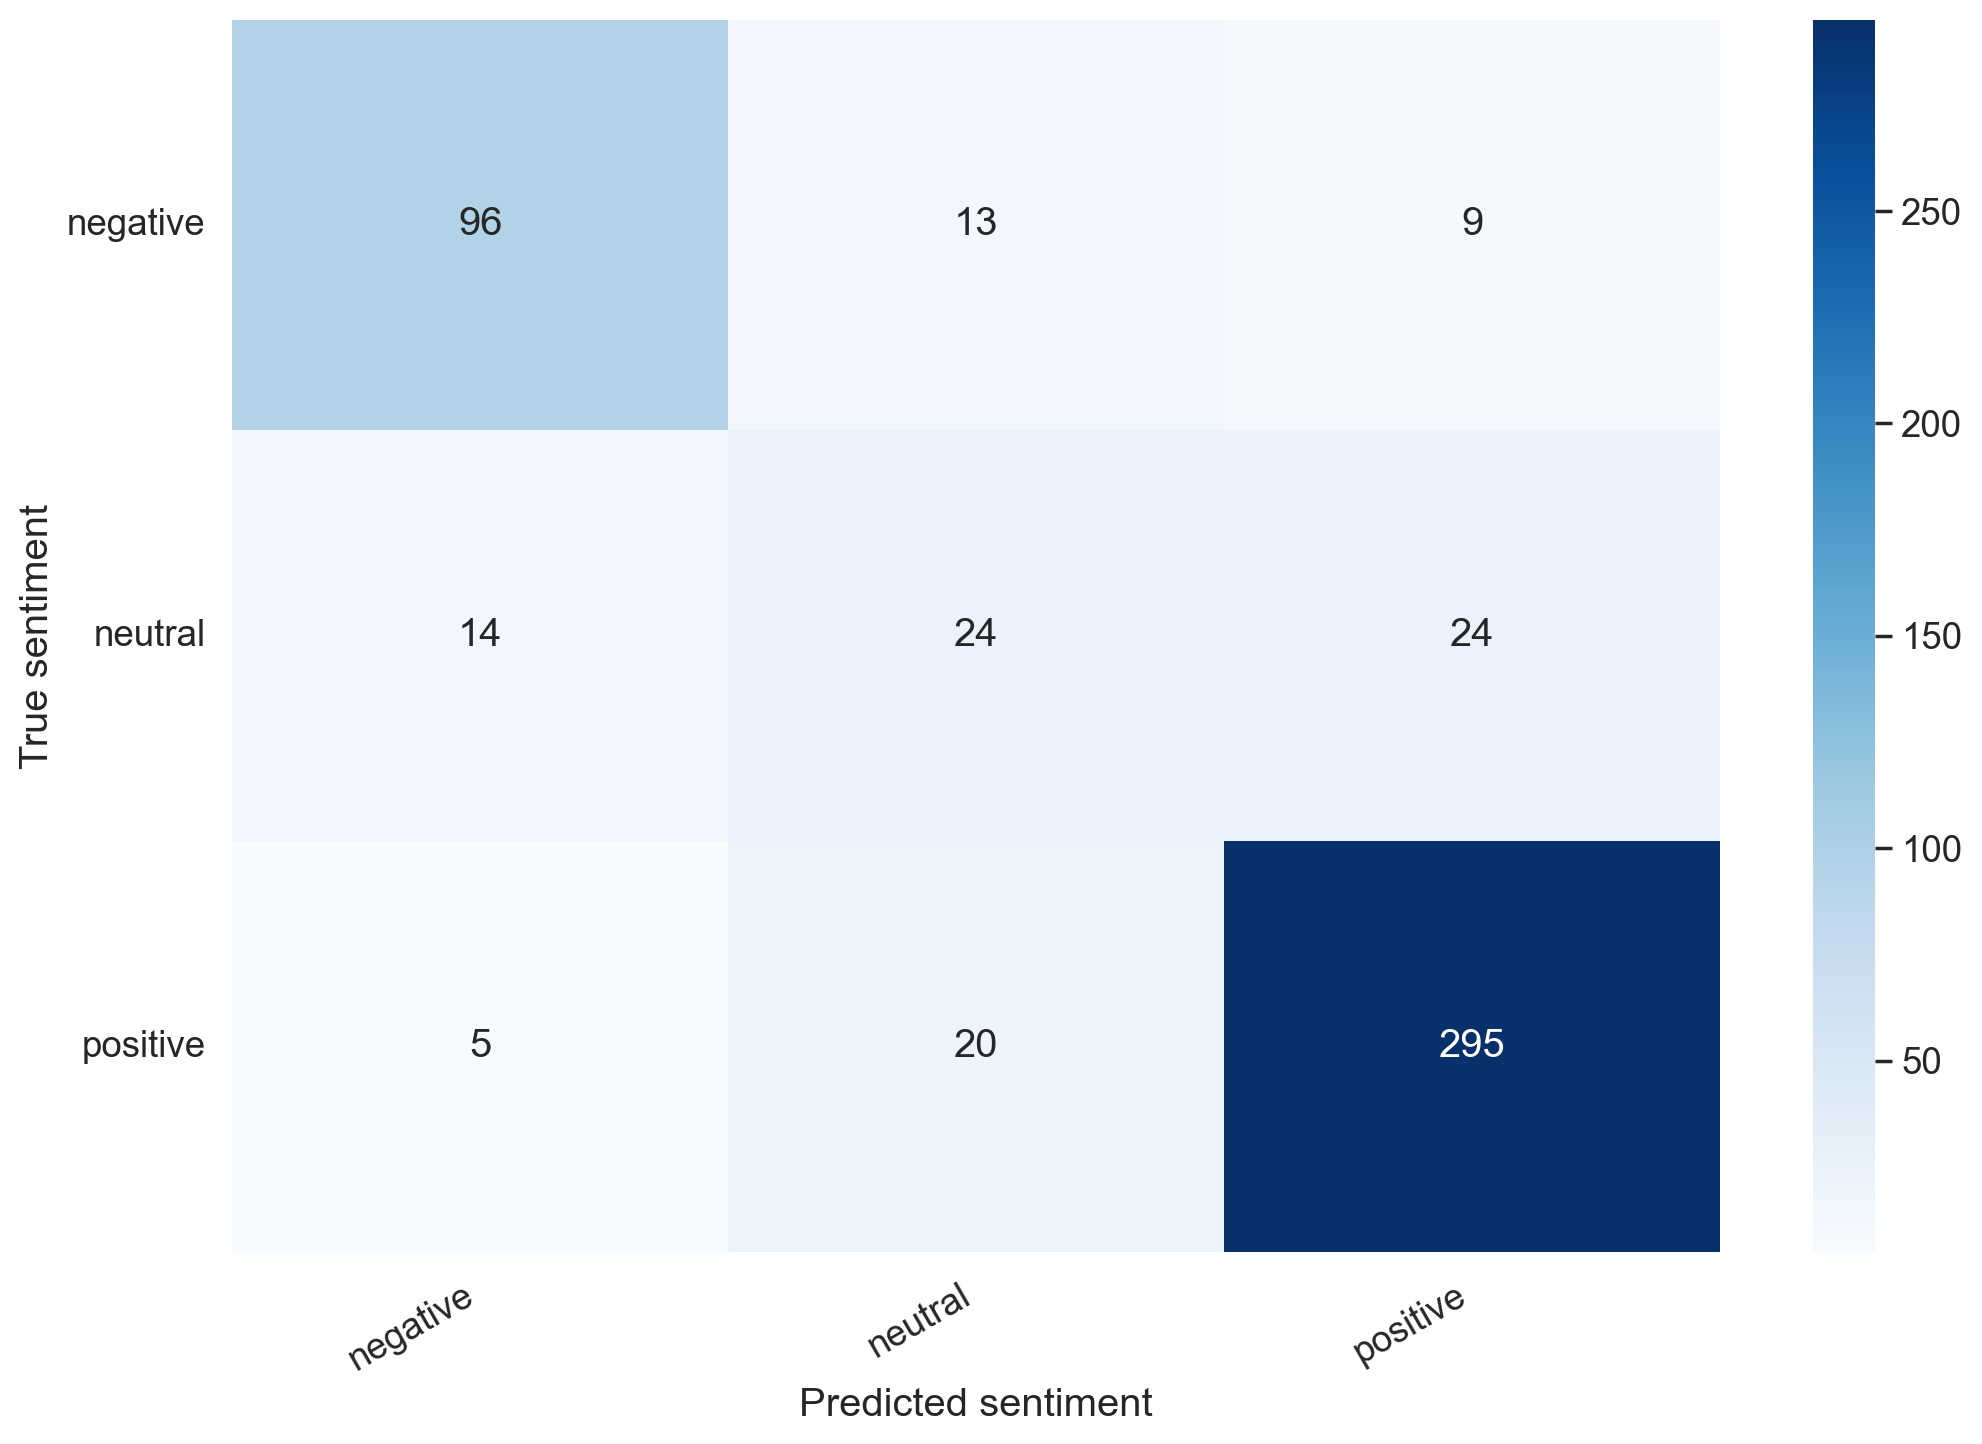

In [797]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)


In [804]:
# Predicting on raw textfor testing
review_text = "food was horrible. but the place was nice"


In [805]:
encoded_review = tokenizer.encode_plus(
    review_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
)


In [806]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: food was horrible. but the place was nice
Sentiment  : negative
